In [3]:
import numpy as np
import json
import matplotlib.pyplot as plt
# from tools.tools import run_model
from tools import dirs
import tellurium as te
from data.observations import observations
from tools.dirs import dir_model
from models.models import Macrophage
from models.params import fixed_params
from plots.plots import P1_3_eq_plot, P1_3_qualitative_plot, P1_3_plot

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 
plt.rcParams["font.family"] = "serif"
plt.style.use('seaborn-deep')
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
%config Completer.use_jedi = False
showOriginalModelString = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
##--- import matlab model and edits it to remove invalid ids----#####
import sys
import tellurium as te
from tools.dirs import dir_model,dir_matlab_model
from tools.tools import edit_matlab_model
edit_matlab_model(input_file=dir_matlab_model,output_file=dir_model)
model = te.loadSBMLModel(dir_model)
print(model.getAntimony())
# run_model(model=model,params = {},duration=200,target_keys=['Mg_f','Mg_e'])

P1_3 is plotting


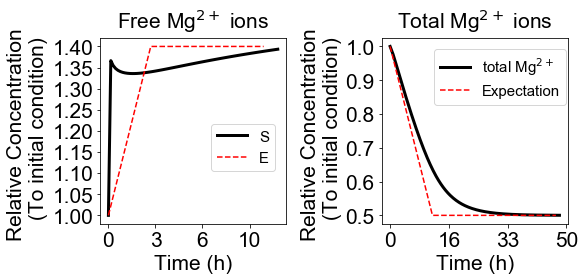

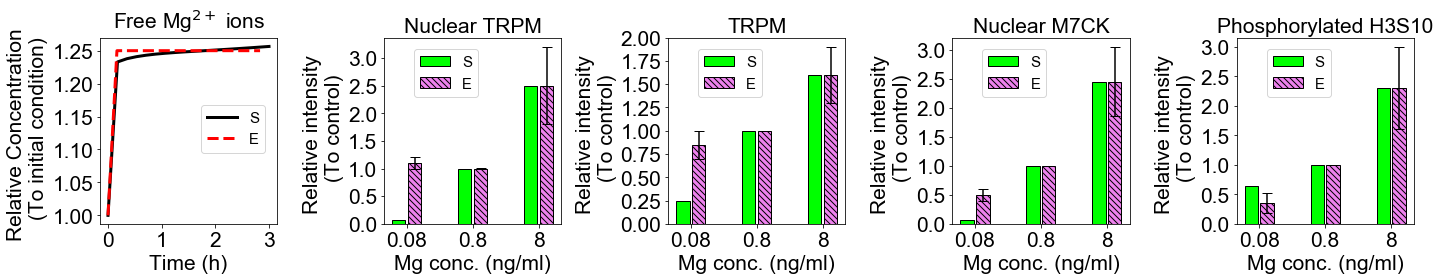

In [51]:
# --------- plot ------------##

# from plots.plots import P1_3_eq_plot, P1_3_qualitative_plot, P1_3_plot
# from plots.plots import P1_3_plot

model_sbml = te.loadSBMLModel(dir_model)

with open(dirs.dir_calib_output,'r') as file:
    inferred_params = json.load(file)
params = {**inferred_params,**fixed_params}

macrophage_obj = Macrophage(observations=observations)

flags = {
    'P1_3': True,
}
for key,value in flags.items():
    if key == 'P1_3' and value : 
        print('P1_3 is plotting')
#         P1_3_eq_plot(model_sbml=model_sbml,params=params)
        P1_3_qualitative_plot (model_sbml=model_sbml,params=params)
        P1_3_plot (model_sbml=model_sbml,model_macrophage=macrophage_obj,params=params)

In [44]:
### delete late####
from tools.dirs import dir_model
model = te.loadSBMLModel(dir_model)
#model.exportToSBML(dir_model)
with open(dirs.dir_calib_output,'r') as file:
    inferred_params = json.load(file)
params = inferred_params
inputs = {'Mg_e':19}
for key,value in inputs.items():
    params[key]=value
target_keys = ['Mg_f','Mg_ATP','Mg','Mg_n']
duration = 1*60
results = run_model(model,params = params,target_keys=target_keys,duration=duration)
model.plot()
print(results['Mg'])
results['Mg_n']

NameError: name 'run_model' is not defined

In [ ]:
from data.observations import observations

x = observations['R05_19']['measurement_scheme']['Mg_Mg_ATP']
y1 = observations['R05_19']['Mg_19']['expectations']['Mg_Mg_ATP']['mean']
# y2 = observations['eq_mg']['Mg_10']['expectations']['Mg']['mean']
# y3 = observations['eq_mg']['Mg_20']['expectations']['Mg']['mean']
plot(x=x,y=y1)

In [ ]:
###----testing the calibrated model vs Qiao Mg-----####
params = {**inferred_params,'Mg_e':8}
model_obj = Macrophage(fixed_params = {}, free_params = params,observations=observations)
results_study = model_obj.simulate_study('Q21_Mg')
x = observations['Q21_Mg']['measurement_scheme']['Mg']
exp = observations['Q21_Mg']['Mg_8']['expectations']['Mg']["mean"]
sim = [(i/min(results_study['Mg_8']['Mg']))*100 for i in results_study['Mg_8']['Mg']]
fig = plt.figure(figsize=(2,2))
fig.canvas.draw()
ax = fig.add_subplot(1, 1, 1)
ax.plot(sim,label = 'S')
ax.plot(exp,label = 'E')
ax.legend()
ax.set_title('Mg2+ ions')
ax.set_xticks(range(len(x)))
ax.set_xticklabels(x)
ax.set_xlabel('Minutes')
plt.show()

In [ ]:
##-----sample from the original model --------###
Zhao_2021 = te.loadSBMLModel(dir_Zhao_model)
inputs = {'pIKK':[50]}
targets = {'NFKB_n':[i for i in range(0,500,10)]}
target_keys = list(targets.keys())
simulation_duration = 1500
if len(list(inputs.keys()))>1:
    raise ValueError('the rest of the code is designed for 1 key input')
results = []
for key, values in inputs.items():
#     rr_dict_i={'inputs'}
    for value in values:
        results_i = run_Zhao_model(target_keys=target_keys,params = {key:value},duration=simulation_duration,step=simulation_duration)
        rr_dict = {}
        for target_key,target_time in targets.items():
            results_key = list([results_i[target_key][i] for i in target_time])
            rr_dict[target_key] = {'time':target_time,'values':results_key}
        results.append({'inputs': {key:value},'results':rr_dict})
with open(dir_samples_Zhao_model, 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

In [ ]:
###------experiment small implementation------####
test_model = """
    model pathway()
        x_0 = 1;
        x = 10;
        y = 1;
        k_0 = 0.1;
        k = .1;
        n = 10;
        x_0 -> x; k_0;
        x -> y; k*x^n;
    end
"""
mm = te.loada(test_model)
target_keys = ['x','y']
results = run_model(mm,params = {'k':1,'n':3},target_keys = target_keys,duration = 10)

mm.plot()

In [ ]:
###------calibrate the model according on the samples taken from the Zhao model ----##
## load the samples from the original model
with open(dir_samples_Zhao_model) as json_file:
    samples = json.load(json_file)
## load the model
model = te.loadSBMLModel(dir_model)
## define the free parameters
free_params = dict( 
    IL8 = [0,100000], 
    K248 = [0,1],  # IL8 regulates TRAF6
    Kd248 = [0,1000], # IL8 regulates TRAF6
)
calib_Obj = Calibrate(model = model,free_params=free_params,target=samples,max_iteration=50)
inferred_params = calib_Obj.optimize()
print(inferred_params)

In [ ]:
###----testing the calibrated model vs Zhao-----####
fig = plt.figure(figsize=(2,2))
fig.canvas.draw()
duration = 500
i = 0
for key,values in inputs.items():
    for value in values:
        ax = fig.add_subplot(1, 1, i+1)
        if True: # plot Zhao model 
            results = run_Zhao_model(target_keys = ['IKK','pIKK','NFKB','NFKB_n'],params={key:value},step=duration,duration=duration)
            ax.plot(results['NFKB_n'],label = 'Zhao')
        if True: # model
            target_keys = ['NFKB_n']
            inferred_params[key] = value
            results = run_model(model=model,params = inferred_params,target_keys=target_keys,step=duration,duration=duration)
            ax.plot(results['NFKB_n'],label = 'Sim')
        ax.set_title('NFKB_n + %d'%value)
        ax.legend()
        i+=1

plt.show()

In [ ]:
### repo##
model_Mg = """
  ##------variables and initial conditions-----##
  Mg_e = 1; # external Mg2+ => input

  TRPM = 10;
  TRPM_n = 10;
  Mg_f = 0.5; # free Mg in cytoplasm
  Mg_ATP = 10; 
  Mg := Mg_f+Mg_ATP
  
  ATP = 10;
  ##------boundary variables----------#
  ATP_prod = 1;
  TRPM_prod = 1;
  ##------parameters-------------##
  K11 = .1; K12 = 0.1; n1 = 1;# Mg flux

  K21 = 10 ; K22 = 10; Kd2 = 10; n2 = 2; # ATP production 
  K4 = .1; # ATP consumption

  K31 = 0.1; K32 = 0.1; # ATP.Mg production

  K5 = 10; # TRPM production

  K6 = 0.1; #cytoplasm translocation of TRPM

  K7 = 0.1; #segmentation of TRPM to M7CK

  K8 = 0.1; #nuclear translocation of M7CK

  ##------reactions -----------###
  V1: $Mg_e => Mg_f; K11*(Mg_e-Mg_f)*TRPM
  V1: Mg_f => $Mg_e; K12*(Mg_f-Mg_e) # mg import/export
  #V1: $Mg_e -> Mg_f; K11*Mg_e-K12*Mg_f # mg import/export
  V2: $ATP_prod -> ATP; K21*Mg_f^n2/(Mg_f^n2+Kd2)+K22;
  V4: ATP-> ;K4*ATP;
  V3: Mg_f + 5 ATP -> Mg_ATP; K31*Mg_f*ATP-K32*Mg_ATP; 
  V5: $TRPM_prod + Mg_ATP => TRPM_n + Mg_ATP; K5*Mg_ATP # transcription of TRPM_n 
  V6: TRPM_n => TRPM; K6*TRPM_n; 
  V7: TRPM => M7CKs; K7*TRPM; # segmentation of TRPM to M7CKs
  #V8: M7CKs -> M7CKs_n; K8*M7CKs; #nuclear translocation of M7CKs
  #M7CKs -> deg; K*M7CKs; # my assummption
  #$H3S10_prod -> H3S10; K; 
  #H3S10 -> pH3S10; k*H3S10*f(M7CKs_n)-K*pH3S10 #
  #$IL8_prod + pH3S10 -> pH3S10 + IL8; K*f(pH3S10)*(1/(IL8+Kd));
  #$IKB_prod + pH3S10 -> pH3S10 + IKB_n; K*f(pH3S10)*(1/(IKB_n+Kd);
  
  ##-----repo----###
  #V5: Mg_ATP -> Mg_ATP_n; K*Mg_ATP-K*Mg_ATP_n # Mg goes to the nucleus #skipped for now

  """
model = te.loada(model_Mg)
model.exportToSBML(dir_model)
# model.getCurrentAntimony()
if False: #running from the macrophage class
    obj = Macrophage(fixed_params = {},free_params=inferred_params,observations = observations)
    results = obj.simulate_study('R05_19')
    error = obj.run()
    print(results)

def cost_function(params_values):
    ## create the parameter set for the given parameter values
    params = {}
    for key,value in zip(free_params.keys(),params_values):
        params[key] = value
    results = run_model(model=model, params = params, target_keys= sample_target_keys)
    tag_errors=[]
    for tag in sample_target_keys:
        n_abs_values= []
        for i in range(len(samples['time'])):
            index = indexing(samples['time'][i],results['time'])
            abs_value = abs(results[tag][index] - samples[tag][i])
#             mean_value = np.mean([results[tag][i], samples[tag][i]])
            mean_value = samples[tag][i]
            n_abs_values.append(abs_value/mean_value)
#         print(n_abs_values)
        tag_error = np.mean(n_abs_values)
        tag_errors.append(tag_error)
#     print(tag_errors)
    return np.mean(tag_errors)

###--------- NF-kB pathway------------: 1 ###
""" inputs: pIKK
"""
NF_kB_main_block = """
            ##----variable definition and initial conditions----##
            IKB = 435;
            NFKB = 277;
            IKB_n = 25;
            NFKB_n = 931;
            IKB_NFKB_n = 29;
            IKB_NFKB = 68307;
            pIKB = 143;
            ## dummy variables ##
            IKB_prod = 1;
            ##------------------parameter definition------------##
            k11 = 10; # NFKB disassociation
            Kd11 = 10; # NFKB disassociation
            k12 = 0.5; # degradation of pIKB
            k13 = 0.5; # Nuclear translocation of NFKB and vice versa
            k14 = 0.5; # Nuclear translocation of NFKB and vice versa
            k15 = 10; # IkBa mRNA transcription
            Kd12 = 10; # IkBa mRNA transcription
            k16 = 0.5; # IkBa mRNA cytoplasm translocation and vice versa
            k17 = 0.5; # IkBa mRNA cytoplasm translocation and vice versa
            k18 = 0.5; # NFKB-IkBa bond formation
            k19 = 0.5; # NFKB-IkBa bond formation
            k20 = 0.5; # IkBa degredation
            ##---------------formulations---------------------##
            IKB_NFKB + pIKK => pIKB + NFKB + pIKK; k11*IKB_NFKB*pIKK/(pIKK + Kd11); ## NFkB disassosciation in cytoplasm ##
            pIKB => deg; k12*pIKB; ## pIKB degradation ##
            NFKB => NFKB_n; k13*NFKB-k14*NFKB_n ; ## Nuclear translocation of NFKB and vice versa ##
            $IKB_prod + NFKB_n => IKB_n + NFKB_n; k15*NFKB_n/(NFKB_n+Kd12); ## IkBa mRNA transcription ##
            IKB -> IKB_n; k16*IKB - k17*IKB_n; ## IkBa mRNA cytoplasm translocation and vice versa ##
            NFKB + IKB -> IKB_NFKB; k18*NFKB*IKB - k19*IKB_NFKB; ## NFKB-IkBa bond formation ##
            IKB => deg; k20*IKB; ## IkBa degredation ##
        """
free_params = dict( 
    k11 = [0,1000000], # NFKB disassociation
    Kd11 = [0,1000000], # NFKB disassociation
    k12 = [0,1], # degradation of pIKB
    k13 = [0,1], # Nuclear translocation of NFKB and vice versa
    k14 = [0,1], # Nuclear translocation of NFKB and vice versa
    k15 = [0,1000000], # IkBa mRNA transcription
    Kd12 = [0,1000000], # IkBa mRNA transcription
    k16 = [0,1], # IkBa mRNA cytoplasm translocation and vice versa
    k17 = [0,1], # IkBa mRNA cytoplasm translocation and vice versa
    k18 = [0,1], # NFKB-IkBa bond formation
    k19 = [0,1], # NFKB-IkBa bond formation
    k20 = [0,1], # IkBa degredation
)
###----- ode dolver-----###
if False:
    from scipy.integrate import odeint
    y0 = [50.0, 0.0,0.0]
    z = 10
    K = 1
    b = 5
    time_l = 10
    def func(y, t, z, K,b):
        xy,x,y = y
        dydt = [-K*xy*(z/(z+b)),K*xy*(z/(z+b)), K*xy*(z/(z+b))]
        return dydt
    t = np.linspace(0, time_l, 101)
    sol = odeint(func, y0, t, args=(z,K,b))
    xy = [sol[i][0] for i in range(len(sol))]
    x = [sol[i][1] for i in range(len(sol))]
    y = [sol[i][2] for i in range(len(sol))]
    plot(x,'x')
###--------- NF-kB pathway Zhao------------ ###
""" inputs: pIKK
"""
NF_kB_main_block = """
            ##----variable definition and initial conditions----##
            IKB = 435;
            NFKB = 277;
            IKB_n = 25;
            NFKB_n = 931;
            IKB_NFKB_n = 29;
            IKB_NFKB = 68307;
            pIKB = 143;
            ## dummy variables ##
            IKB_prod = 1;
            ##------------------parameter definition------------##
            k217 = 0.8;
            ## NFkB disassosciation ##
            k222 = 240;
            ka222 = 10000000;
            ## Nuclear translocation of NFKB  and vice versa ##
            k219 = 0.1;
            ## IkBa mRNA transcription ##
            k221 = 0.2;
            ## IkBa mRNA cytoplasm translocation and vice versa ##
            kf220 = 0.1;
            kr220 = 0.8;
            ## NFKB-IkBa bond formation ##
            kf216 = 0.001;
            kr216 = 6e-05;
            ## degradation ##
            k226 = 0.1; # IKB
            ## new variables
            K21 = 0.5; # degradation of pIKB
            ##---------------formulations---------------------##
            IKB_NFKB + pIKK => pIKB + NFKB + pIKK; k222*IKB_NFKB*pIKK/(pIKK + ka222); ## NFkB disassosciation in cytoplasm ##
            pIKB => deg; K21*pIKB; ## pIKB degradation ##
            NFKB => NFKB_n; k219*NFKB ; ## Nuclear translocation of NFKB ##
            $IKB_prod + NFKB_n => IKB_n + NFKB_n; k221*NFKB_n; ## IkBa mRNA transcription ##
            IKB -> IKB_n; kf220*IKB - kr220*IKB_n; ## IkBa mRNA cytoplasm translocation and vice versa ##
            NFKB + IKB -> IKB_NFKB; kf216*NFKB*IKB - kr216*IKB_NFKB; ## NFKB-IkBa bond formation ##
            NFKB_n + IKB_n -> IKB_NFKB_n; kf216*NFKB_n*IKB_n - kr216*IKB_NFKB_n;##  NFkB sassosciation in nucleus ##
            IKB_NFKB_n => IKB_NFKB; k217*IKB_NFKB_n; ## translocation of IKB_NFKB_n to cytoplasm
            IKB => deg; k226*IKB; ## IkBa degredation ##
        """
####--------- test ------------###
if False:
#     test_model_script = """
#                 ##----variable definition and initial conditions----##
#                 y = 0;
#                 x = 0;
#                 xy = 50;
#                 z=10;
#                 K=1;
#                 b=1000;
#                 z = 100;
#                 xy + z -> x + y + z; K*xy*z/(z+b);
#                 """
    test_model_script = """
                x = 0;
                x_prod = 1;
                Kd = 10;
                $x_prod -> x; 10*Kd/(Kd+x);
                """
    test_model = te.loada(test_model_script)
    results = run_model(model=test_model,params={},target_keys=['x'],duration=100000)
    plot(results['x'],'x')